In [1]:
from __future__ import print_function
import os
import tarfile
import pickle
import urllib
import argparse
import math
import cntk
import numpy as np

import cntk as C
from cntk.logging import *
from cntk import input, cross_entropy_with_softmax, classification_error
from cntk import Trainer, cntk_py 
from cntk.learners import momentum_sgd, learning_rate_schedule, momentum_as_time_constant_schedule, UnitType
from cntk.debugging import set_computation_network_trace_level
from cntk.device import try_set_default_device, gpu
from cntk import data_parallel_distributed_learner, block_momentum_distributed_learner, Communicator
from cntk.train.training_session import *
from cntk.debugging import *

from mmlspark import CNTKLearner
#from resnet_models import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
32,application_1505966830572_0120,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


In [2]:
# Used for debugging
import socket
print(socket.gethostname())

wn0-amlcnt

In [3]:
cdnURL = "https://amldockerdatasets.azureedge.net"
# Please note that this is a copy of the CIFAR10 dataset originally found here:
# http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
dataFile = "cifar-10-python.tar.gz"
dataURL = cdnURL + '/CIFAR10/' + dataFile
if not os.path.isfile(dataFile):
    urllib.urlretrieve(dataURL, dataFile)
with tarfile.open(dataFile, "r:gz") as f:
    test_dict = pickle.load(f.extractfile("cifar-10-batches-py/test_batch"))

In [4]:
# Create the images with labels from CIFAR dataset, reformat the labels using OneHotEncoder
import array
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import col
from pyspark.sql.types import *

def reshape_image(record):
    image, label, filename = record
    data = [float(x) for x in image.reshape(3,32,32).flatten()]
    return data, label, filename

convert_to_double = udf(lambda x: x, ArrayType(DoubleType()))

image_rdd = zip(test_dict["data"], test_dict["labels"], test_dict["filenames"])
image_rdd = spark.sparkContext.parallelize(image_rdd).map(reshape_image)

imagesWithLabels = image_rdd.toDF(["images", "labels", "filename"])

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

imagesWithLabels = imagesWithLabels.withColumn("images", list_to_vector_udf(convert_to_double(col("images"))))\
  .select("images", "labels")

ohe = OneHotEncoder().setInputCol("labels").setOutputCol("tmplabels").setDropLast(False)
imagesWithLabels = ohe.transform(imagesWithLabels).select("images", "tmplabels").withColumnRenamed("tmplabels", "labels")

imagesWithLabels.printSchema()

imagesWithLabels.cache()
print(imagesWithLabels.count())

root
 |-- images: vector (nullable = true)
 |-- labels: vector (nullable = true)

10000

In [5]:
# model dimensions - these match the ones from convnet_cifar10_dataaug
# so we can use the same data source
image_height = 32
image_width  = 32
num_channels = 3  # RGB
num_classes  = 10
model_name   = "ResNet_CIFAR10_DataAug.model"

# Create network
def create_resnet_network(network_name):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width), name='features')
    label_var = C.input_variable((num_classes), name='labels')

    # create model, and configure learning parameters 
    if network_name == 'resnet20': 
        z = create_cifar10_model(input_var, 3, num_classes)
    elif network_name == 'resnet110': 
        z = create_cifar10_model(input_var, 18, num_classes)
    else: 
        return RuntimeError("Unknown model name!")

    # loss and metric
    ce = cross_entropy_with_softmax(z, label_var)
    pe = classification_error(z, label_var)

    return {
        'name' : network_name,
        'feature': input_var,
        'label': label_var,
        'ce' : ce,
        'pe' : pe,
        'output': z
    }

In [6]:
# The learner can't be serialized in CNTK currently (tracked by https://github.com/Microsoft/CNTK/issues/2409)
# We can define it in text and pass it to the GPU VM
learner = """import numpy as np
from cntk.learners import momentum_sgd, learning_rate_schedule, momentum_as_time_constant_schedule, UnitType
max_epochs = 100
epoch_size = 50000
minibatch_size = 128
momentum_time_constant = -minibatch_size/np.log(0.9)
lr_per_mb = [1.0]*80+[0.1]*40+[0.01]
l2_reg_weight = 0.0001
# Set learning parameters
lr_per_sample = [lr/minibatch_size for lr in lr_per_mb]
lr_schedule = learning_rate_schedule(lr_per_sample, epoch_size=epoch_size, unit=UnitType.sample)
mm_schedule = momentum_as_time_constant_schedule(momentum_time_constant)

# learner object
local_learner = momentum_sgd(model.parameters, lr_schedule, mm_schedule, l2_regularization_weight = l2_reg_weight)
"""

In [7]:
def create_trainer(network, minibatch_size, epoch_size, num_quantization_bits, block_size, warm_up, progress_printer):
    if network['name'] == 'resnet20': 
        lr_per_mb = [1.0]*80+[0.1]*40+[0.01]
    elif network['name'] == 'resnet110': 
        lr_per_mb = [0.1]*1+[1.0]*80+[0.1]*40+[0.01]
    else: 
        return RuntimeError("Unknown model name!")
    model = network['output']
    # Execute the learner code
    exec(learner)
    
    return Trainer(model, (network['ce'], network['pe']), local_learner, progress_printer)

In [8]:
from cntk.initializer import he_normal
from cntk.layers import AveragePooling, BatchNormalization, Convolution, Dense
from cntk.ops import element_times, relu

def conv_bn(input, filter_size, num_filters, strides=(1,1), init=he_normal()):
    c = Convolution(filter_size, num_filters, activation=None, init=init, pad=True, strides=strides, bias=False)(input)
    r = BatchNormalization(map_rank=1, normalization_time_constant=4096, use_cntk_engine=False)(c)
    return r

def conv_bn_relu(input, filter_size, num_filters, strides=(1,1), init=he_normal()):
    r = conv_bn(input, filter_size, num_filters, strides, init) 
    return relu(r)

def resnet_basic(input, num_filters):
    c1 = conv_bn_relu(input, (3,3), num_filters)
    c2 = conv_bn(c1, (3,3), num_filters)
    p  = c2 + input
    return relu(p)

def resnet_basic_inc(input, num_filters, strides=(2,2)):
    c1 = conv_bn_relu(input, (3,3), num_filters, strides)
    c2 = conv_bn(c1, (3,3), num_filters)
    s  = conv_bn(input, (1,1), num_filters, strides)
    p  = c2 + s
    return relu(p)

def resnet_basic_stack(input, num_stack_layers, num_filters): 
    assert (num_stack_layers >= 0)
    l = input 
    for _ in range(num_stack_layers): 
        l = resnet_basic(l, num_filters)
    return l 

def create_cifar10_model(input, num_stack_layers, num_classes):
    c_map = [16, 32, 64]

    conv = conv_bn_relu(input, (3,3), c_map[0])
    r1 = resnet_basic_stack(conv, num_stack_layers, c_map[0])

    r2_1 = resnet_basic_inc(r1, c_map[1])
    r2_2 = resnet_basic_stack(r2_1, num_stack_layers-1, c_map[1])

    r3_1 = resnet_basic_inc(r2_2, c_map[2])
    r3_2 = resnet_basic_stack(r3_1, num_stack_layers-1, c_map[2])

    # Global average pooling and output
    pool = AveragePooling(filter_shape=(8,8), name='final_avg_pooling')(r3_2)
    z = Dense(num_classes, name='z')(pool)
    return z

In [9]:
# setup the progress printer
minibatch_size = 128
epoch_size = 50000
num_quantization_bits = 32
block_size = None
warm_up = 0

num_mbs_per_log = None
log_to_file = None
gen_heartbeat = False
max_epochs = 100

progress_printer = ProgressPrinter(
    freq=num_mbs_per_log,
    tag='Training',
    log_to_file=log_to_file,
    gen_heartbeat=gen_heartbeat,
    num_epochs=max_epochs)

network_name = 'resnet20'

In [10]:
network = create_resnet_network(network_name)

In [11]:
trainer = create_trainer(network, minibatch_size, epoch_size, num_quantization_bits, block_size, warm_up, progress_printer)

In [12]:
# Split the images with labels into a train and test data
train, test = imagesWithLabels.randomSplit([0.6, 0.4], seed=123)
train.printSchema()
train.show(5)

root
 |-- images: vector (nullable = true)
 |-- labels: vector (nullable = true)

+--------------------+--------------+
|              images|        labels|
+--------------------+--------------+
|[0.0,0.0,0.0,0.0,...|(10,[7],[1.0])|
|[1.0,1.0,1.0,1.0,...|(10,[1],[1.0])|
|[2.0,0.0,0.0,1.0,...|(10,[1],[1.0])|
|[3.0,1.0,2.0,3.0,...|(10,[3],[1.0])|
|[4.0,2.0,3.0,4.0,...|(10,[2],[1.0])|
+--------------------+--------------+
only showing top 5 rows

In [13]:
# Specify the working directory and GPU node name and GPU count
workingDir = "file:/tmp/workdir33/"
gpum = ["mygpuvm,2"]
print(workingDir)

file:/tmp/workdir33/

In [14]:
# Train the distributed learner using 4 GPUs on the VM
learner = CNTKLearner(dataTransfer='hdfs-mount',\
            gpuMachines=gpum, workingDir=workingDir).setPythonModel(trainer, learner).fit(train)

In [15]:
# Evaluate the model
scoredImages = learner.setOutputNodeName('z').setInputCol("images").setOutputCol("scored").transform(test)
scoredImages.show(10)

+--------------------+--------------+--------------------+
|              images|        labels|              scored|
+--------------------+--------------+--------------------+
|[0.0,0.0,1.0,1.0,...|(10,[6],[1.0])|[-2.4394035339355...|
|[0.0,0.0,3.0,20.0...|(10,[6],[1.0])|[-3.0155405998229...|
|[1.0,0.0,1.0,1.0,...|(10,[3],[1.0])|[0.39400804042816...|
|[4.0,5.0,5.0,4.0,...|(10,[8],[1.0])|[0.01754713058471...|
|[5.0,4.0,2.0,2.0,...|(10,[0],[1.0])|[0.02495755255222...|
|[9.0,9.0,13.0,20....|(10,[5],[1.0])|[-2.0497543811798...|
|[10.0,6.0,15.0,32...|(10,[4],[1.0])|[-2.8726565837860...|
|[10.0,8.0,15.0,56...|(10,[1],[1.0])|[0.45021855831146...|
|[10.0,11.0,12.0,1...|(10,[9],[1.0])|[-0.7689878940582...|
|[12.0,15.0,27.0,3...|(10,[6],[1.0])|[-1.0228059291839...|
+--------------------+--------------+--------------------+
only showing top 10 rows

In [16]:
# Transform the log probabilities to predictions
def argmax(x): return max(enumerate(x),key=lambda p: p[1])[0]
argmaxUDF = udf(argmax, IntegerType())
imagePredictions = scoredImages.withColumn("predictions", argmaxUDF("scored"))\
                               .withColumn("labels", argmaxUDF("labels")) \
                               .select("predictions", "labels")
imagePredictions.registerTempTable("ImagePredictions")

In [17]:
%%sql -q -o imagePredictions
select * from ImagePredictions

In [18]:
%%local
y, y_hat = imagePredictions["labels"], imagePredictions["predictions"]

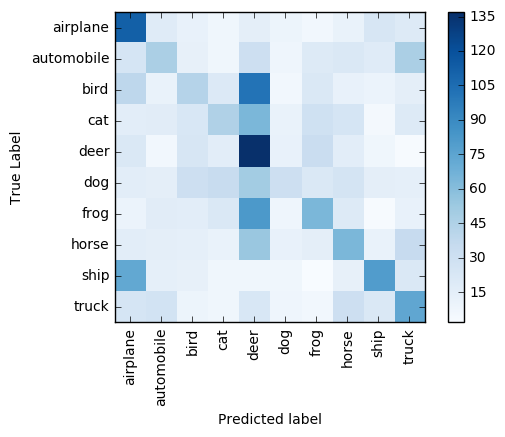

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_hat)

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted label")
plt.ylabel("True Label")
plt.show()